# **Data Pre-processing**
Here we load in the SCADA, turbine level data, and combine it with local historical forecasts from OpenMeteo. 

In [ ]:
# load libraries and directory
import sys
from pathlib import Path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import seaborn as sb
import numpy as np
from utils import *
import warnings
import seaborn as sns
import openmeteo_requests
import requests_cache
from retry_requests import retry
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

### **1. Load Kelmarsh SCADA data**

In [4]:
dct_scada, dct_logs = load_kelmarsh_data("../data/kelmarsh_data/SCADA/")

Loading SCADA data & Logs...


In [5]:
print(list(dct_scada.keys()))

wind = dct_scada["T01"]
wind.tail(2)

['T01', 'T02', 'T03', 'T04', 'T05', 'T06']


,Wind speed (m/s),"Wind speed, Standard deviation (m/s)","Wind speed, Minimum (m/s)","Wind speed, Maximum (m/s)",Long Term Wind (m/s),Wind speed Sensor 1 (m/s),"Wind speed Sensor 1, Standard deviation (m/s)","Wind speed Sensor 1, Minimum (m/s)","Wind speed Sensor 1, Maximum (m/s)",Wind speed Sensor 2 (m/s),...,"Tower Acceleration Y, Min (mm/s2)","Tower Acceleration Y, Max (mm/s2)","Drive train acceleration, Max (mm/s2)","Drive train acceleration, Min (mm/s2)","Drive train acceleration, StdDev (mm/s2)","Tower Acceleration X, StdDev (mm/s2)","Tower Acceleration Y, StdDev (mm/s2)",Night Time,MTBF (Contractual Global) (h),MTTR (Contractual Global) (h)
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-12-31 23:40:00+00:00,10.955464,1.294765,9.068215,13.934932,6.77,11.629940,1.256601,9.65641,14.848926,11.092289,...,23.112547,125.188530,14.885607,14.885607,0.0,45.236639,25.429970,1.0,NaN,NaN
2023-12-31 23:50:00+00:00,10.564928,1.263002,7.738026,12.870558,6.77,11.301769,1.185976,9.22965,12.633566,10.845575,...,14.718814,99.877098,14.535666,14.535666,0.0,26.135971,21.011821,1.0,NaN,NaN


**Clean SCADA Power Curves**

In [6]:
def process_scada_with_logs(dct_scada, dct_logs):
    dct_scada_flagged = {}
    dct_scada_clean = {}

    for turbine_id in dct_logs:
        # 1. Process logs for status intervals
        df_log = dct_logs[turbine_id].reset_index()

        status_intervals = {}
        for status in ["Stop", "Warning", "Curtailment"]:
            intervals = (
                df_log.loc[df_log["Status"] == status, ["Timestamp start", "Timestamp end"]]
                .rename(columns={"Timestamp start": "start", "Timestamp end": "end"})
            )
            intervals = intervals[intervals["end"] != "-"]
            intervals["start"] = pd.to_datetime(intervals["start"], utc=True, errors="coerce")
            intervals["end"] = pd.to_datetime(intervals["end"], utc=True, errors="coerce")
            intervals = intervals.dropna()
            status_intervals[status.lower()] = intervals

        # 2. Copy SCADA data and add status flags
        wind = dct_scada[turbine_id].copy()
        wind[["status_stop", "status_warning"]] = 0

        for status, intervals in status_intervals.items():
            col_name = f"status_{status}"
            for start, end in intervals[["start", "end"]].values:
                wind.loc[start:end, col_name] = 1

        dct_scada_flagged[turbine_id] = wind

        # 3. Apply cleaning filters
        running = wind['status_stop'] == 0
        no_warning = wind['status_warning'] == 0
        valid_wind = wind['Wind speed (m/s)'] > 0.1

        curtailment_cols = [col for col in wind.columns if 'Curtailment' in col and 'kWh' in col]
        no_curtailment = (wind[curtailment_cols] == 0).all(axis=1) if curtailment_cols else True

        not_derated = wind['Turbine Power setpoint (kW)'] >= 0.99 * wind['Potential power default PC (kW)']

        valid_mask = running & no_warning & valid_wind & no_curtailment & not_derated

        dct_scada_clean[turbine_id] = wind[valid_mask].copy()

    return dct_scada_flagged, dct_scada_clean

dct_scada_flagged, dct_scada_clean = process_scada_with_logs(dct_scada, dct_logs)

In [7]:
for turbine_id, wind in dct_scada_clean.items():
    print(f"Turbine {turbine_id} - Cleaned data shape: {wind.shape}, Raw data shape: {dct_scada[turbine_id].shape}, Reduced by: {1 - wind.shape[0] / dct_scada[turbine_id].shape[0]:.2%}")

Turbine T01 - Cleaned data shape: (95591, 321), Raw data shape: (104483, 318), Reduced by: 8.51%
Turbine T02 - Cleaned data shape: (77152, 321), Raw data shape: (104967, 318), Reduced by: 26.50%
Turbine T03 - Cleaned data shape: (94053, 321), Raw data shape: (104754, 318), Reduced by: 10.22%
Turbine T04 - Cleaned data shape: (81650, 321), Raw data shape: (102756, 318), Reduced by: 20.54%
Turbine T05 - Cleaned data shape: (79543, 321), Raw data shape: (104671, 318), Reduced by: 24.01%
Turbine T06 - Cleaned data shape: (52480, 321), Raw data shape: (104561, 318), Reduced by: 49.81%


### **2. Load OpenMeteo NWP data**

In [16]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Define all weather variables 
weather_variables = ["relative_humidity_2m", "wind_direction_80m", "wind_speed_80m", "temperature_80m", "wind_gusts_10m", "surface_pressure", "precipitation"]

# API request parameters
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
	"latitude": 52.400604,
	"longitude": -0.947133,
	"start_date": "2022-01-01",
	"end_date": "2024-12-31",
	"hourly": weather_variables,
	"models": "gfs_global",
	"timezone": "auto",
}

# Make API request
responses = openmeteo.weather_api(url, params=params)
response = responses[0]

print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone: {response.Timezone()}{response.TimezoneAbbreviation()}")

# Process hourly data efficiently
hourly = response.Hourly()

# Create time index
time_range = pd.date_range(
    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=hourly.Interval()),
    inclusive="left"
)

# Build dataframe directly
weather_data = {"date": time_range}

# Add all variables programmatically
for i, var_name in enumerate(weather_variables):
    weather_data[var_name] = hourly.Variables(i).ValuesAsNumpy()

# Create final dataframe
weather_df = pd.DataFrame(weather_data)
weather_df.set_index('date', inplace=True)

print(f"\nWeather data shape: {weather_df.shape}")
print(f"Date range: {weather_df.index.min()} to {weather_df.index.max()}")
print("\nFirst few rows:")
print(weather_df.head())

Coordinates: 52.42433166503906°N -0.9375°E
Elevation: 146.0 m asl
Timezone: b'Europe/London'b'GMT+1'

Weather data shape: (26304, 7)
Date range: 2021-12-31 23:00:00+00:00 to 2024-12-31 22:00:00+00:00

First few rows:
                           relative_humidity_2m  wind_direction_80m  \
date                                                                  
2021-12-31 23:00:00+00:00                  93.0          211.171280   
2022-01-01 00:00:00+00:00                  91.0          217.349426   
2022-01-01 01:00:00+00:00                  90.0          209.886444   
2022-01-01 02:00:00+00:00                  84.0          208.009079   
2022-01-01 03:00:00+00:00                  79.0          209.248734   

                           wind_speed_80m  temperature_80m  wind_gusts_10m  \
date                                                                         
2021-12-31 23:00:00+00:00       34.080421          10.7005       48.959999   
2022-01-01 00:00:00+00:00       34.417206          

### **3. Combine**

In [17]:
# Create the all_power_df and farm_power_missing mask
all_power_df = pd.DataFrame()
turbine_ids = ['T01', 'T02', 'T03', 'T04', 'T05', 'T06']
for turbine_id in turbine_ids:
    power_series = dct_scada_clean[turbine_id]['Power (kW)'].rename(turbine_id)
    all_power_df = pd.concat([all_power_df, power_series], axis=1)

# Ensure datetime index for all_power_df
if not isinstance(all_power_df.index, pd.DatetimeIndex):
    all_power_df.index = pd.to_datetime(all_power_df.index)

# Create the farm-wide outage mask
resampled_power = all_power_df.sort_index().loc['2022-01-01':].resample('H').mean()
farm_power_missing = resampled_power.isnull().all(axis=1)

# Turbine coordinates
coords = {
    'T01': [52.4006, -0.94713, 145.598],
    'T02': [52.40255, -0.94953, 156.577], 
    'T03': [52.40383, -0.94419, 153.477],
    'T04': [52.39878, -0.94115, 146.313],
    'T05': [52.40231, -0.94054, 142.901],
    'T06': [52.40069, -0.93609, 135.039]
}

turbine_datasets = {}
for turbine_id in turbine_ids:
    # Get turbine SCADA data and ensure datetime index
    turbine_data = dct_scada_clean[turbine_id].copy()
    if not isinstance(turbine_data.index, pd.DatetimeIndex):
        turbine_data.index = pd.to_datetime(turbine_data.index)
    
    turbine_df = turbine_data.loc['2022-01-01':].sort_index().resample('H').mean()
    
    # Add spatial features (constant per turbine)
    lat, lon, elev = coords[turbine_id]
    turbine_df['latitude'] = lat
    turbine_df['longitude'] = lon  
    turbine_df['elevation'] = elev

    # Ensure weather_df has datetime index
    weather_df_copy = weather_df.copy()
    if not isinstance(weather_df_copy.index, pd.DatetimeIndex):
        weather_df_copy.index = pd.to_datetime(weather_df_copy.index)

    # Merge with weather (same for all turbines)
    turbine_df = weather_df_copy.merge(
        turbine_df, 
        left_index=True, right_index=True, how='left', 
    )

    # Interpolate missing values for all columns
    turbine_df = turbine_df.interpolate(method='linear', limit_direction='both')

    # --- FIX: Align indices before applying the mask ---
    # Only apply the mask to timestamps that exist in both DataFrames
    common_timestamps = turbine_df.index.intersection(farm_power_missing.index)
    mask_aligned = farm_power_missing.loc[common_timestamps]
    
    # Set power to 0 during farm-wide outages (only for common timestamps)
    turbine_df.loc[mask_aligned[mask_aligned].index, 'Power (kW)'] = 0
    # --- END FIX ---

    # Create trigonometric features
    turbine_df['f_wind_dir_80m_sin'] = np.sin(np.deg2rad(turbine_df['wind_direction_80m']))
    turbine_df['f_wind_dir_80m_cos'] = np.cos(np.deg2rad(turbine_df['wind_direction_80m']))

    turbine_df['wind_dir_sin'] = np.sin(np.deg2rad(turbine_df['Wind direction (°)']))
    turbine_df['wind_dir_cos'] = np.cos(np.deg2rad(turbine_df['Wind direction (°)']))

    turbine_df['blade_angle_sin'] = np.sin(np.deg2rad(turbine_df['Blade angle (pitch position) A (°)']))
    turbine_df['blade_angle_cos'] = np.cos(np.deg2rad(turbine_df['Blade angle (pitch position) A (°)']))

    # Select feature columns
    feature_cols = [
        # SCADA 
        'Power (kW)', 'Wind speed (m/s)', 'wind_dir_sin', 'wind_dir_cos',
        'Ambient temperature (converter) (°C)', 'Nacelle temperature (°C)',
        'Rotor bearing temp (°C)', 'blade_angle_sin', 'blade_angle_cos',
        
        # Spatial 
        'latitude', 'longitude', 'elevation',

        # Weather 1hr ahead forecasts
        'wind_speed_80m', 'surface_pressure', 'f_wind_dir_80m_sin', 'f_wind_dir_80m_cos', 
        'temperature_80m', "wind_gusts_10m", "precipitation"
    ]
    
    turbine_datasets[turbine_id] = turbine_df[feature_cols]

# Save
# pd.to_pickle(turbine_datasets, "data_masked.pkl")

# Show results
print("Turbine datasets created:", list(turbine_datasets.keys()))
print("\nFirst few rows of T01:")
print(turbine_datasets['T01'].head())
print(f"\nFarm outages detected: {farm_power_missing.sum()} timestamps")

Turbine datasets created: ['T01', 'T02', 'T03', 'T04', 'T05', 'T06']

First few rows of T01:
                            Power (kW)  Wind speed (m/s)  wind_dir_sin  \
date                                                                     
2021-12-31 23:00:00+00:00   868.619661          7.269199     -0.177551   
2022-01-01 00:00:00+00:00   868.619661          7.269199     -0.177551   
2022-01-01 01:00:00+00:00   852.641219          7.180542     -0.228769   
2022-01-01 02:00:00+00:00  1104.675791          7.924514     -0.234467   
2022-01-01 03:00:00+00:00  1090.165807          7.761178     -0.201072   

                           wind_dir_cos  Ambient temperature (converter) (°C)  \
date                                                                            
2021-12-31 23:00:00+00:00     -0.984112                             14.690000   
2022-01-01 00:00:00+00:00     -0.984112                             14.690000   
2022-01-01 01:00:00+00:00     -0.973481                         

In [14]:
print(turbine_datasets['T01'].tail())

                            Power (kW)  Wind speed (m/s)  wind_dir_sin  \
date                                                                     
2024-01-01 18:00:00+00:00  2038.112888         11.527731     -0.947211   
2024-01-01 19:00:00+00:00  2038.112888         11.527731     -0.947211   
2024-01-01 20:00:00+00:00  2038.112888         11.527731     -0.947211   
2024-01-01 21:00:00+00:00  2038.112888         11.527731     -0.947211   
2024-01-01 22:00:00+00:00  2038.112888         11.527731     -0.947211   

                           wind_dir_cos  Ambient temperature (converter) (°C)  \
date                                                                            
2024-01-01 18:00:00+00:00     -0.320612                              12.76125   
2024-01-01 19:00:00+00:00     -0.320612                              12.76125   
2024-01-01 20:00:00+00:00     -0.320612                              12.76125   
2024-01-01 21:00:00+00:00     -0.320612                              12.7612

## **4. Exploratory Data Analysis**

**Correlations**

<Axes: >

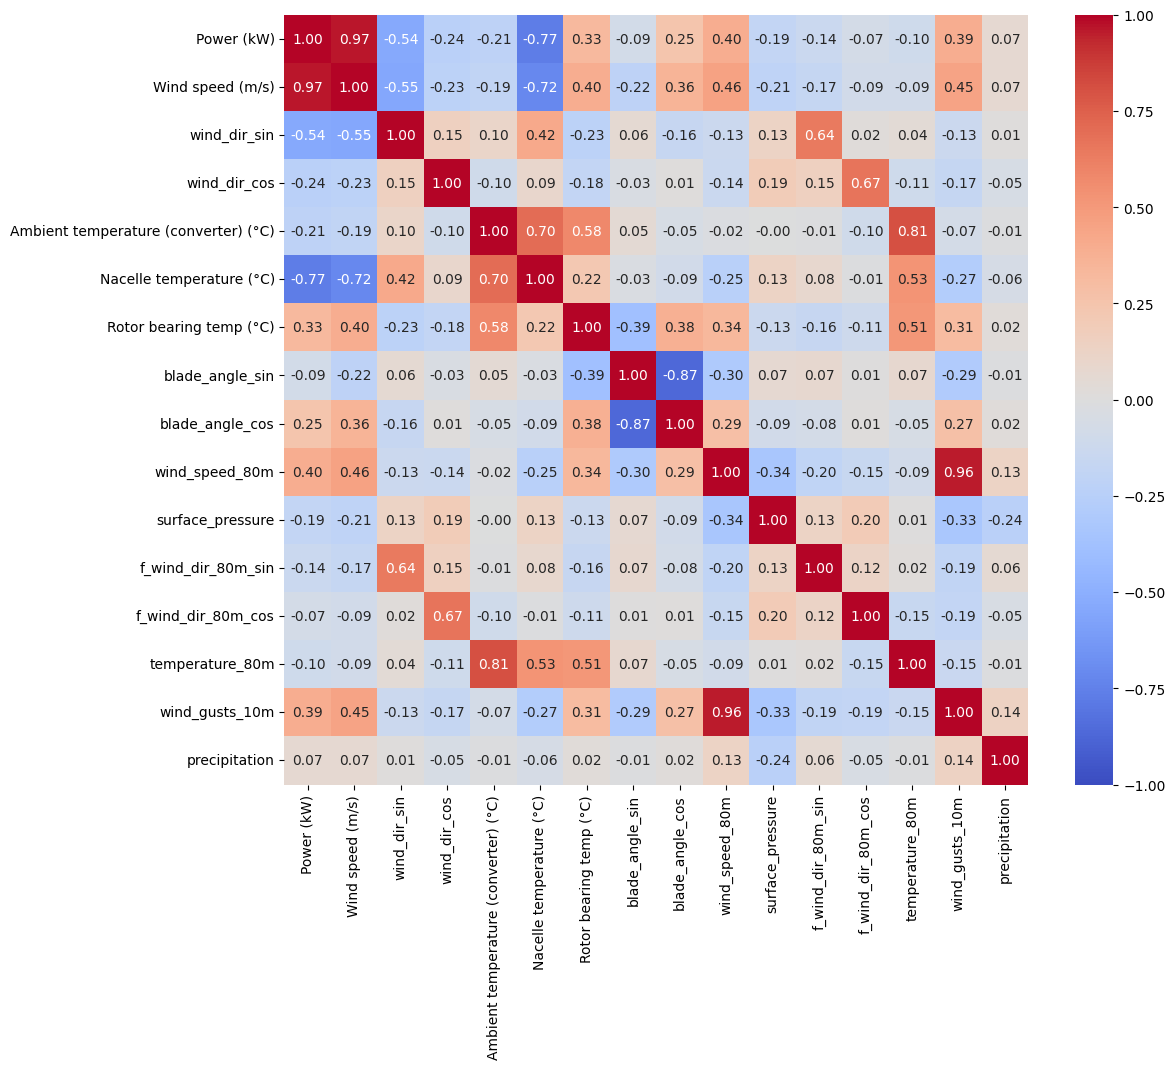

In [19]:
plt.figure(figsize=(12, 10))
sns.heatmap(turbine_datasets["T01"].drop(columns = ["latitude", "longitude", "elevation"]).corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)

**Power Curves**

In [ ]:
# Style config
STYLE_CONFIG = {
    # FONT
    'font.size': 18,
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'Times New Roman'],
    'mathtext.fontset': 'dejavuserif',

    # AXES
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': False,  

    # TICKS
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 10,
    'ytick.major.size': 10,

    # LEGEND
    'legend.fontsize': 16,
    'legend.frameon': False,

    # FIGURE & SAVING
    'figure.figsize': (8, 5),
    'figure.dpi': 100,
    'figure.facecolor': 'white',
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.format': 'pdf'
}
plt.rcParams.update(STYLE_CONFIG)
sns.set_style("white")
sns.set_context("paper", font_scale=2)  



def plot_clean_vs_dirty_scada(
    dirty_data_dict,
    clean_data_dict,
    save_path=None,
    max_points=5000,
    use_hexbin=False,
    resample_rule='1H',
    close_fig=True
):
    """
    Memory-optimized plotting of SCADA dirty vs clean points per turbine.

    Args:
        dirty_data_dict, clean_data_dict: dict[turbine_id -> DataFrame]
            DataFrames must contain columns: 'Wind speed (m/s)' and 'Power (kW)'.
            Index can be a DatetimeIndex (resampling/asfreq is optional).
        save_path (str): path to save the figure (extension decides format).
        max_points (int): max points to plot per category (trimmed/retained) per turbine.
        use_hexbin (bool): if True, draw a hexbin of all dirty points and overlay retained.
        resample_rule (str|None): e.g. '1H' to call .asfreq('1H'); None to skip.
        close_fig (bool): if True, plt.close(fig) after saving/showing to free memory.
    Returns:
        (fig, axes) if close_fig is False, else (None, None).
    """
    # --- basic checks ---
    key_cols = ['Wind speed (m/s)', 'Power (kW)']
    n_turbines = len(dirty_data_dict)
    if n_turbines == 0:
        raise ValueError("dirty_data_dict is empty")

    cols = 3
    rows = (n_turbines + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), squeeze=False)
    axes_flat = axes.flatten()

    for i, turbine_id in enumerate(dirty_data_dict.keys()):
        ax = axes_flat[i]

        df_dirty = dirty_data_dict[turbine_id].loc['2022-01-01':].sort_index()
        df_clean = clean_data_dict[turbine_id].loc['2022-01-01':].sort_index()

        if resample_rule:
            df_dirty = df_dirty.asfreq(resample_rule)
            df_clean = df_clean.asfreq(resample_rule)

        for name, df in (("dirty", df_dirty), ("clean", df_clean)):
            missing = [c for c in key_cols if c not in df.columns]
            if missing:
                raise KeyError(f"Turbine {turbine_id} missing columns {missing} in {name} dataframe")
        df_dirty = df_dirty.dropna(subset=key_cols)
        df_clean = df_clean.dropna(subset=key_cols)

        df_dirty['Power (kW)'] = df_dirty['Power (kW)'] / 1000
        df_clean['Power (kW)'] = df_clean['Power (kW)'] / 1000

        dirty_pairs = pd.MultiIndex.from_frame(df_dirty[key_cols])
        clean_pairs = pd.MultiIndex.from_frame(df_clean[key_cols])
        mask_retained = dirty_pairs.isin(clean_pairs)   # boolean array, same length as df_dirty

        retained = df_dirty[mask_retained]
        trimmed = df_dirty[~mask_retained]

        # Downsample per-category to limit plotted points
        if len(retained) > max_points:
            retained = retained.sample(max_points, random_state=0)
        if len(trimmed) > max_points:
            trimmed = trimmed.sample(max_points, random_state=0)

        if use_hexbin:
            ax.hexbin(df_dirty['Wind speed (m/s)'], df_dirty['Power (kW)'],
                      gridsize=80, mincnt=1, alpha=0.6)
            if len(retained):
                ax.scatter(retained['Wind speed (m/s)'], retained['Power (kW)'],
                           label='Clean (retained)', s=8, c='red', rasterized=True)
        else:
            if len(trimmed):
                ax.scatter(trimmed['Wind speed (m/s)'], trimmed['Power (kW)'],
                           c='gray', alpha=0.5, s=6, label='Trimmed', rasterized=True)
            if len(retained):
                ax.scatter(retained['Wind speed (m/s)'], retained['Power (kW)'],
                           c='red', alpha=0.6, s=6, label='Clean', rasterized=True)

        ax.set_title(f"Turbine {turbine_id}", fontsize=20, fontweight='bold')
        ax.set_xlabel('Wind Speed (m/s)')
        ax.set_ylabel('Power (MW)')

    for j in range(n_turbines, len(axes_flat)):
        axes_flat[j].set_visible(False)

    handles = labels = None
    for ax in axes_flat[:n_turbines]:
        h, l = ax.get_legend_handles_labels()
        if h:
            handles, labels = h, l
            break
    if handles:
        fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.03), markerscale=6)


    # fig.suptitle("Power Curve Cleaning", y=1)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    if save_path:
        ext = save_path.split('.')[-1].lower()
        if ext not in ('png', 'jpg', 'jpeg', 'pdf'):
            save_path = save_path + '.png'
            ext = 'png'
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved plot to: {save_path}")

    plt.show()

    if close_fig:
        plt.close(fig)
        return None, None
    else:
        return fig, axes

Saved plot to: processed_power_curves.pdf


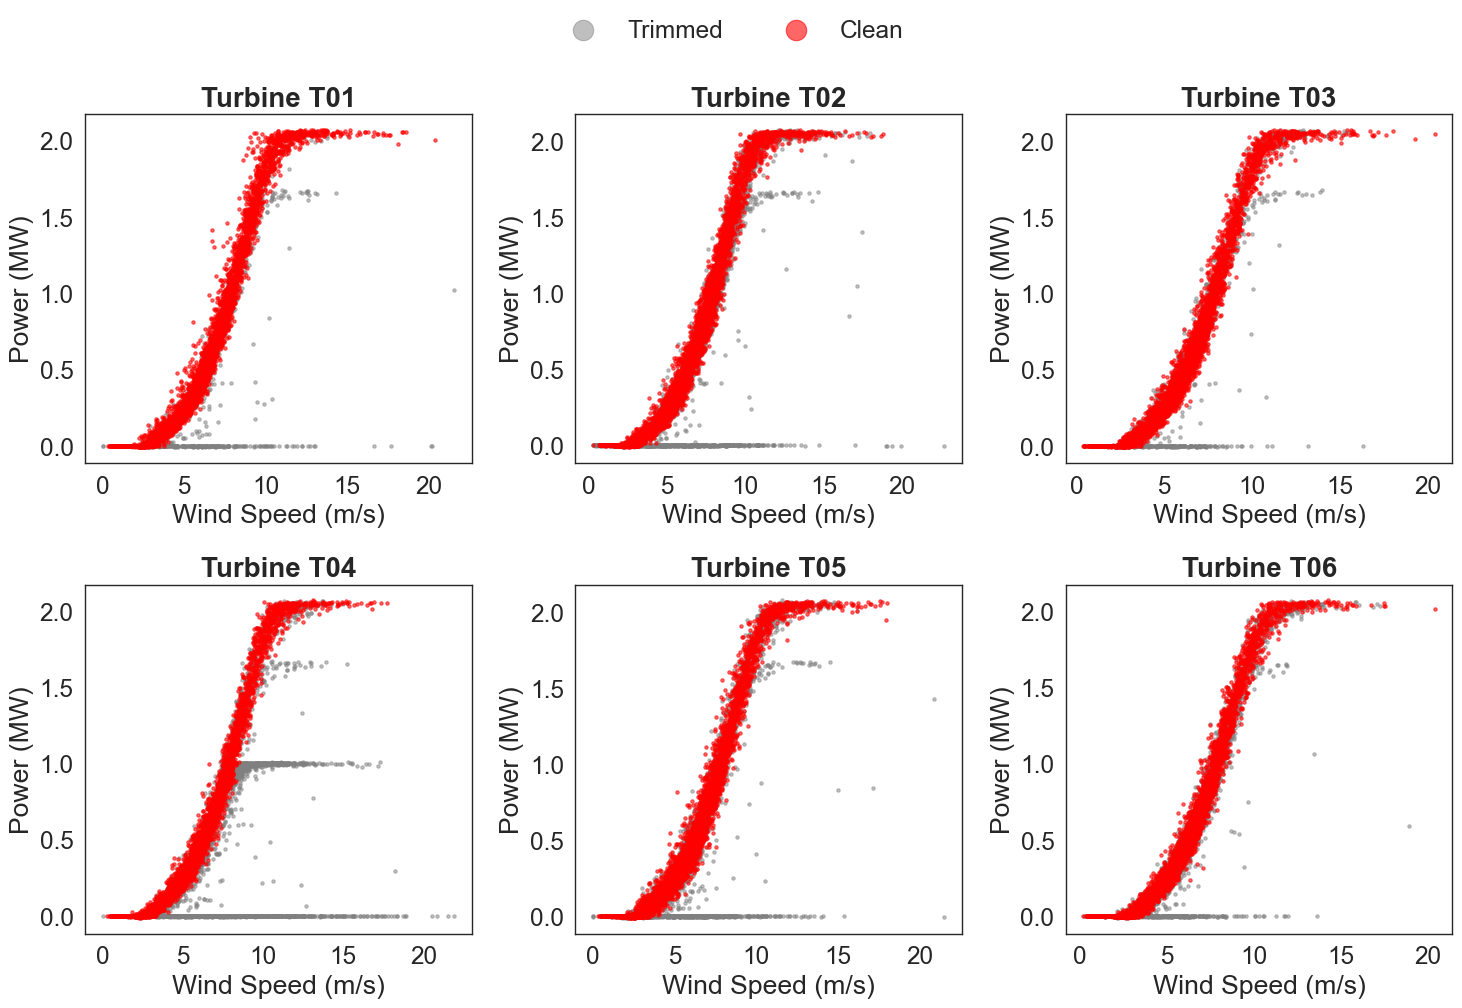

In [62]:
_, _ = plot_clean_vs_dirty_scada(dct_scada, dct_scada_clean, save_path = "processed_power_curves.pdf")

**Temporality / Lag Analysis**

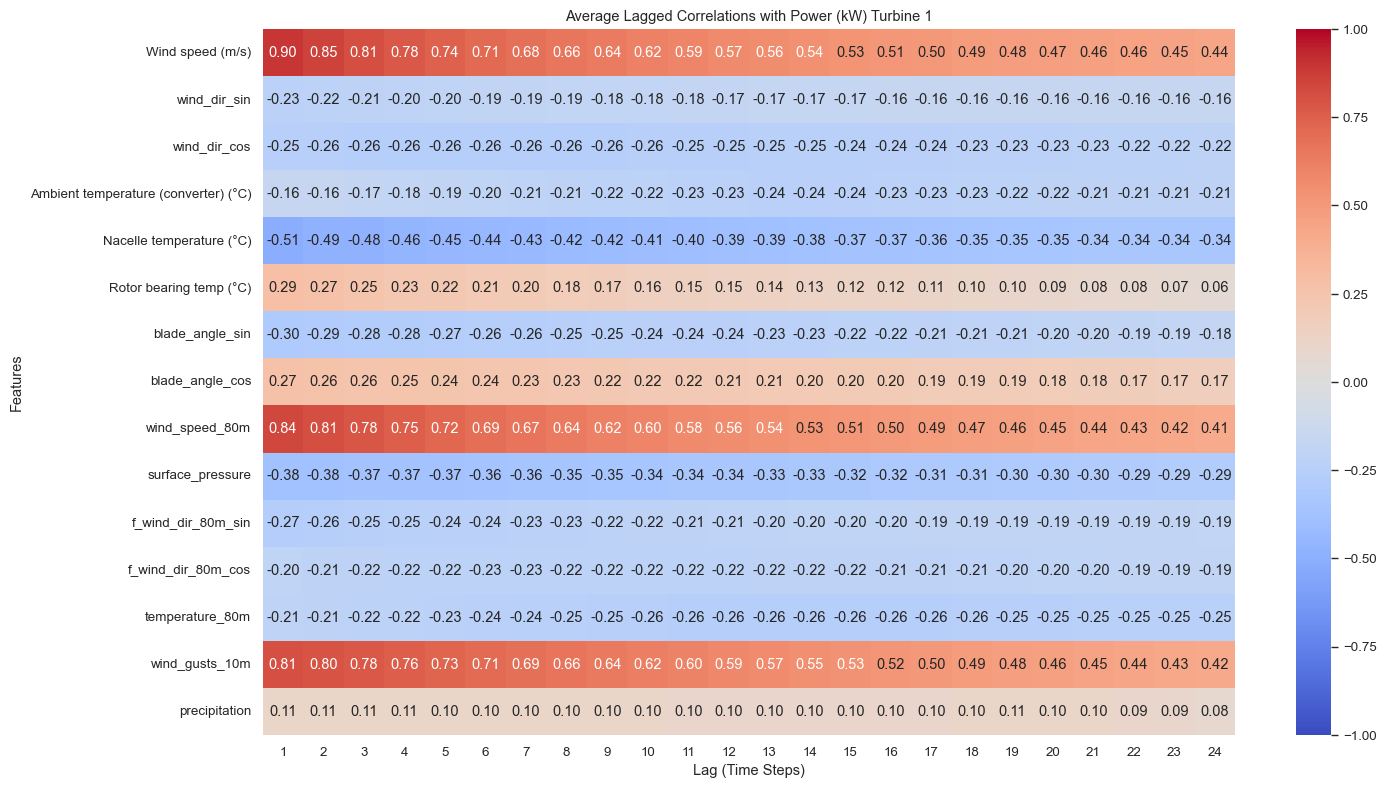

In [12]:
from scipy.stats import pearsonr

max_lag = 24  # Full 24hr lag
target = 'Power (kW)'

# lagged corr func 
def compute_lagged_corrs(df, max_lag, target):
    features = df.columns.drop(target)  # All features except target
    corr_dict = {feat: [] for feat in features}
    lags = range(1, max_lag + 1)
    
    for feat in features:
        for lag in lags:
            # Shift feature by lag (drop NaNs)
            lagged_feat = df[feat].shift(lag).dropna()
            aligned_target = df[target].loc[lagged_feat.index]  
            if len(lagged_feat) > 1: 
                corr, _ = pearsonr(lagged_feat, aligned_target)
                corr_dict[feat].append(corr)
            else:
                corr_dict[feat].append(np.nan)
    
    corr_df = pd.DataFrame(corr_dict, index=lags)
    return corr_df


lag_corr = compute_lagged_corrs(turbine_datasets["T01"].drop(columns = ["latitude", "longitude", "elevation"]), max_lag, target)
plt.figure(figsize=(15, 8))
sns.heatmap(lag_corr.T, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Average Lagged Correlations with Power (kW) Turbine 1')
plt.xlabel('Lag (Time Steps)'); plt.ylabel('Features')
plt.tight_layout(); plt.show()

ValueError: number sections must be larger than 0.

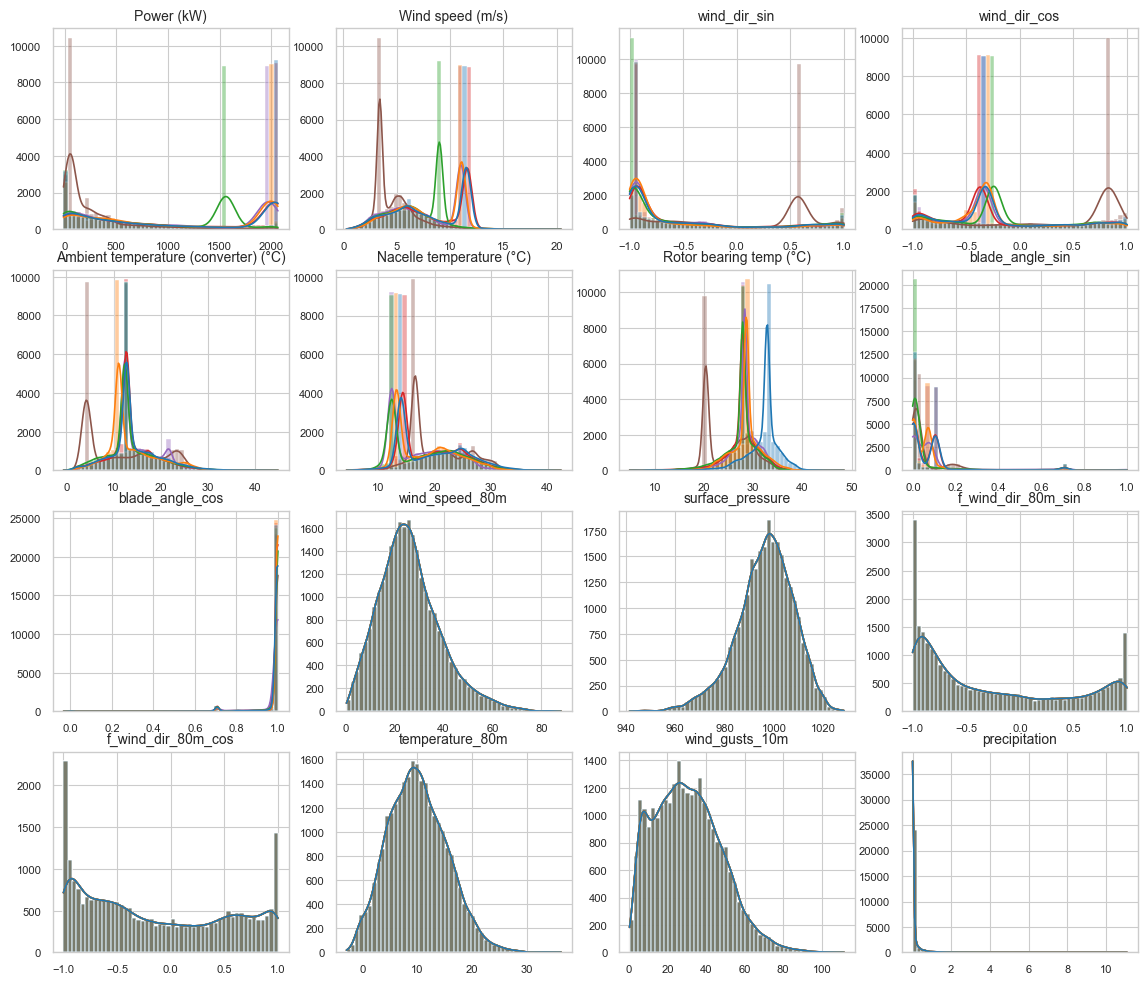

In [63]:
df_all = []
for t_name, df in turbine_datasets.items():
    temp = df.copy()
    temp["Turbine"] = t_name
    df_all.append(temp)
df_all = pd.concat(df_all, ignore_index=True)

# Style for publication
sb.set(style="whitegrid", context="paper", font_scale=1.2)

# Variables to plot
cols = df_all.drop(columns=["longitude", "latitude", "elevation", "Turbine"]).columns

# Prepare multi-panel figure (4 × 4)
fig, axes = plt.subplots(4, 4, figsize=(14, 12))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    sb.histplot(
        data=df_all,
        x=col,
        hue="Turbine",
        kde=True,
        bins=50,
        ax=ax,
        palette="tab10",
        alpha=0.4,  # transparency so overlaps are visible
        edgecolor=None
    )
    ax.set_title(col, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.legend_.remove()  
    
for i in range(len(cols), len(axes)):
    fig.delaxes(axes[i])

# Single legend outside the grid
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Turbine", loc="upper center", ncol=len(labels))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("turbine_distributions_all.png", dpi=300, bbox_inches="tight")
plt.show()